# *MillGuard* — Predictive maintenance for milling equipment  

### Import Package

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import joblib

### Get Dataset

Dataset Overview

This synthetic dataset simulates the operational behavior of a milling machine. It contains 10,000 observations (rows), each representing a single production instance with 14 features (columns). The data is designed to model realistic process conditions and failure mechanisms.

| Feature                     | Description                                                                                                                                                                                               |
| --------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **UID**                     | Unique identifier ranging from 1 to 10,000.                                                                                                                                                               |
| **Product ID**              | A composite identifier consisting of a quality code (`L`, `M`, or `H`) — representing low (50% of samples), medium (30%), and high (20%) quality variants — followed by a variant-specific serial number. |
| **Type**                    | The product quality type extracted from the Product ID (`L`, `M`, or `H`).                                                                                                                                |
| **Air Temperature [K]**     | Simulated using a random walk process, normalized to a standard deviation of 2 K around a mean of 300 K.                                                                                                  |
| **Process Temperature [K]** | Generated from a random walk process normalized to 1 K standard deviation, added to the air temperature plus 10 K.                                                                                        |
| **Rotational Speed [rpm]**  | Calculated based on a power of 2860 W with additional Gaussian noise.                                                                                                                                     |
| **Torque [Nm]**             | Normally distributed around 40 Nm with a standard deviation of 10 Nm, ensuring no negative values.                                                                                                        |
| **Tool Wear [min]**         | Tool wear increases based on product quality: +2 min for L, +3 min for M, and +5 min for H variants.                                                                                                      |
| **Machine Failure**         | Binary label indicating whether the machine failed during this process (1 = failure, 0 = no failure). Failures arise from one or more of the independent failure modes below.                             |


In [41]:
mill_df = pd.read_csv('../dataset/ai4i2020.csv')

In [42]:
mill_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [43]:
mill_df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [44]:
mill_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [45]:
mill_df.isnull().sum() # Check for missing values

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [46]:
mill_df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Machine failure                2
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

### Data Distribution

#### Machine Failure

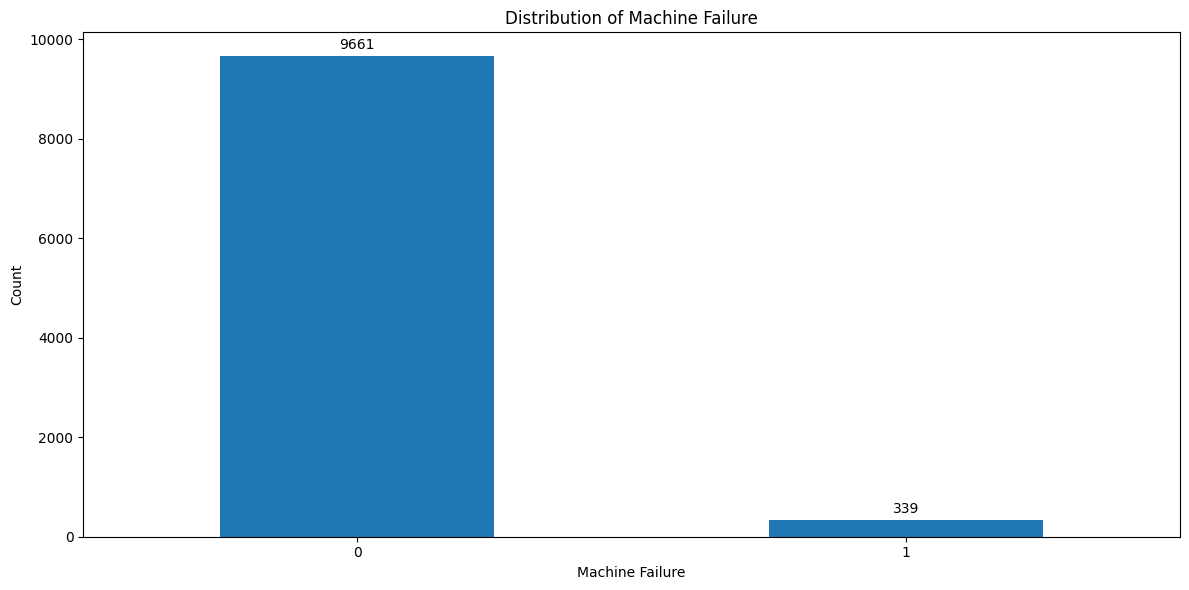

In [47]:
plt.figure(figsize=(12, 6))
counts = mill_df['Machine failure'].value_counts().sort_index()
ax = counts.plot(kind='bar')
plt.title('Distribution of Machine Failure')
plt.xticks(rotation=0)
plt.xlabel('Machine Failure')
plt.ylabel('Count')

# add data labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Type

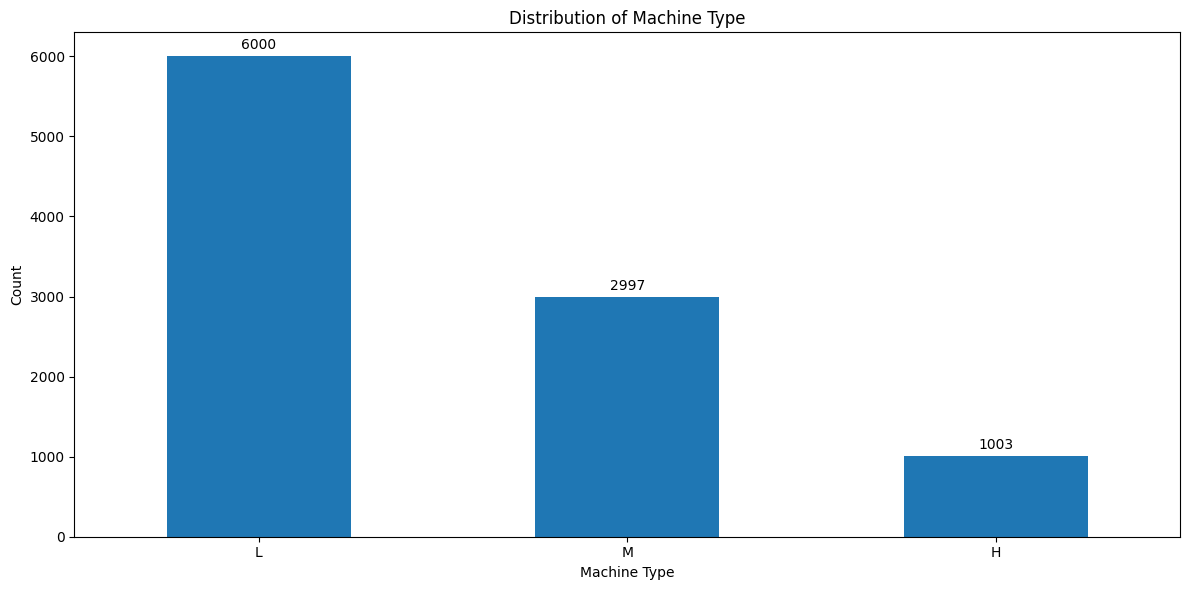

In [48]:
plt.figure(figsize=(12, 6))
# ensure consistent order L, M, H
counts = mill_df['Type'].value_counts().reindex(['L', 'M', 'H']).fillna(0).astype(int)
ax = counts.plot(kind='bar')
plt.title('Distribution of Machine Type')
plt.xticks(rotation=0)
plt.xlabel('Machine Type')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Air temperature [K]

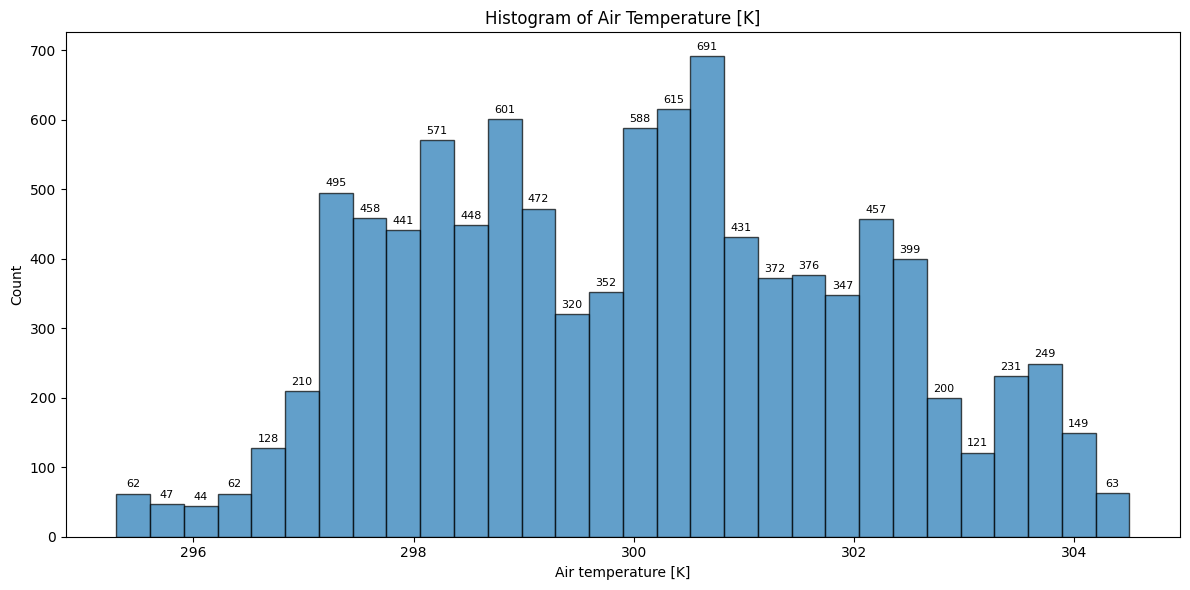

In [49]:
plt.figure(figsize=(12, 6))
data = mill_df['Air temperature [K]']
patches = plt.hist(data, bins=30, color='C0', edgecolor='black', alpha=0.7)[2]
plt.title('Histogram of Air Temperature [K]')
plt.xlabel('Air temperature [K]')
plt.ylabel('Count')

for p in patches:
    h = p.get_height()
    if h > 0:
        plt.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2., h),
                     ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


#### Process temperature [K]

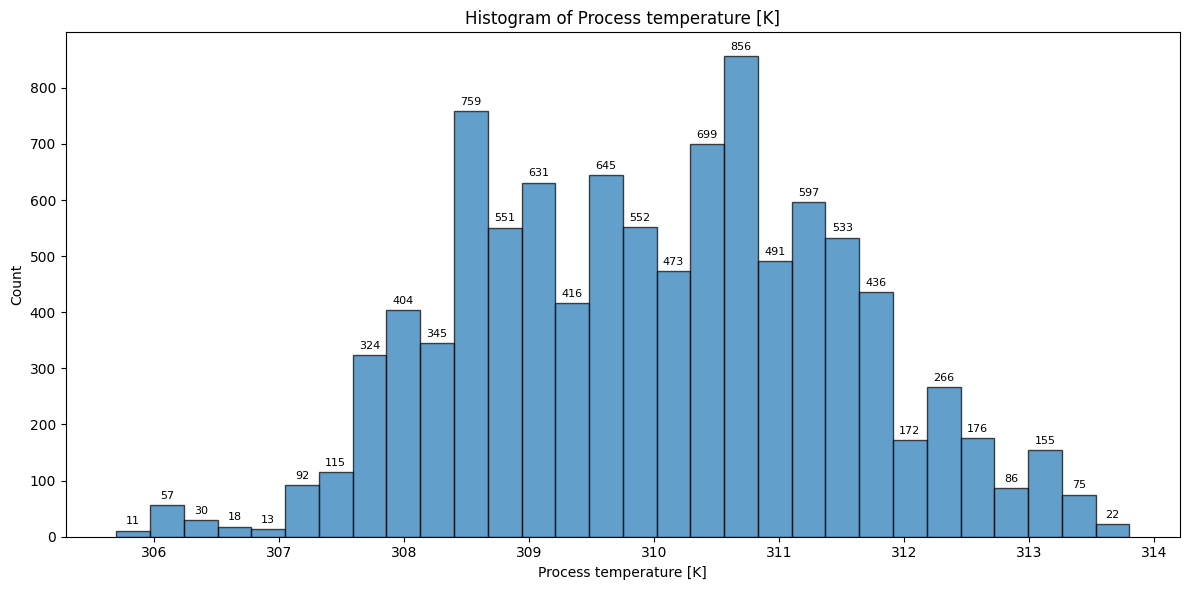

In [50]:
plt.figure(figsize=(12, 6))
data = mill_df['Process temperature [K]']
patches = plt.hist(data, bins=30, color='C0', edgecolor='black', alpha=0.7)[2]
plt.title('Histogram of Process temperature [K]')
plt.xlabel('Process temperature [K]')
plt.ylabel('Count')

for p in patches:
    h = p.get_height()
    if h > 0:
        plt.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2., h),
                     ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


#### Rotational speed [rpm]

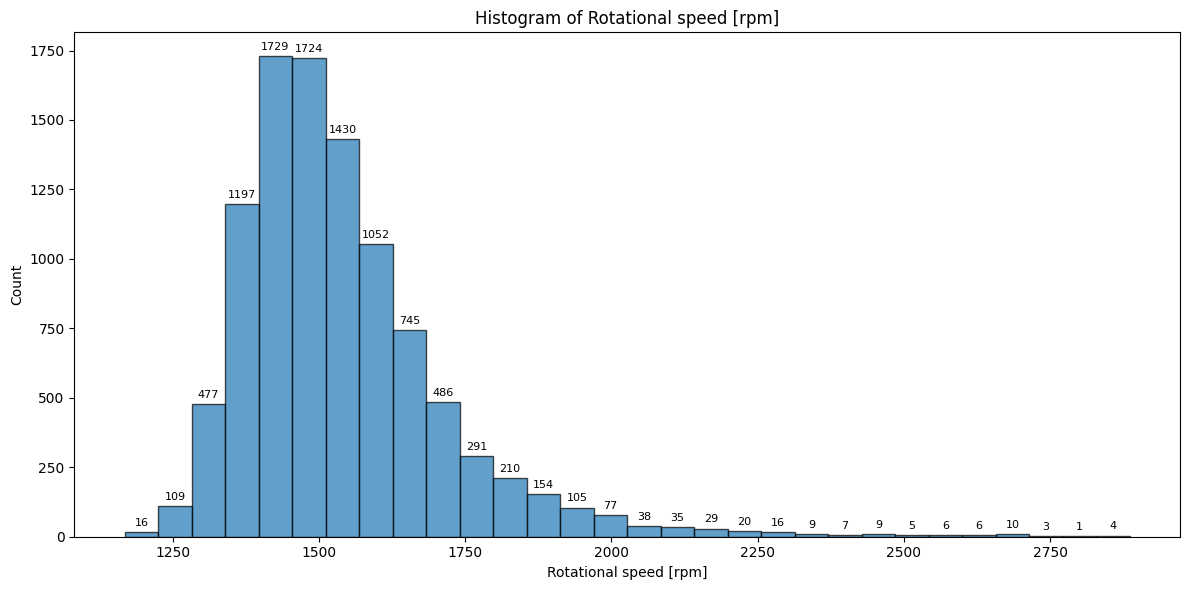

In [51]:
plt.figure(figsize=(12, 6))
data = mill_df['Rotational speed [rpm]']
patches = plt.hist(data, bins=30, color='C0', edgecolor='black', alpha=0.7)[2]
plt.title('Histogram of Rotational speed [rpm]')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Count')

for p in patches:
    h = p.get_height()
    if h > 0:
        plt.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2., h),
                     ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


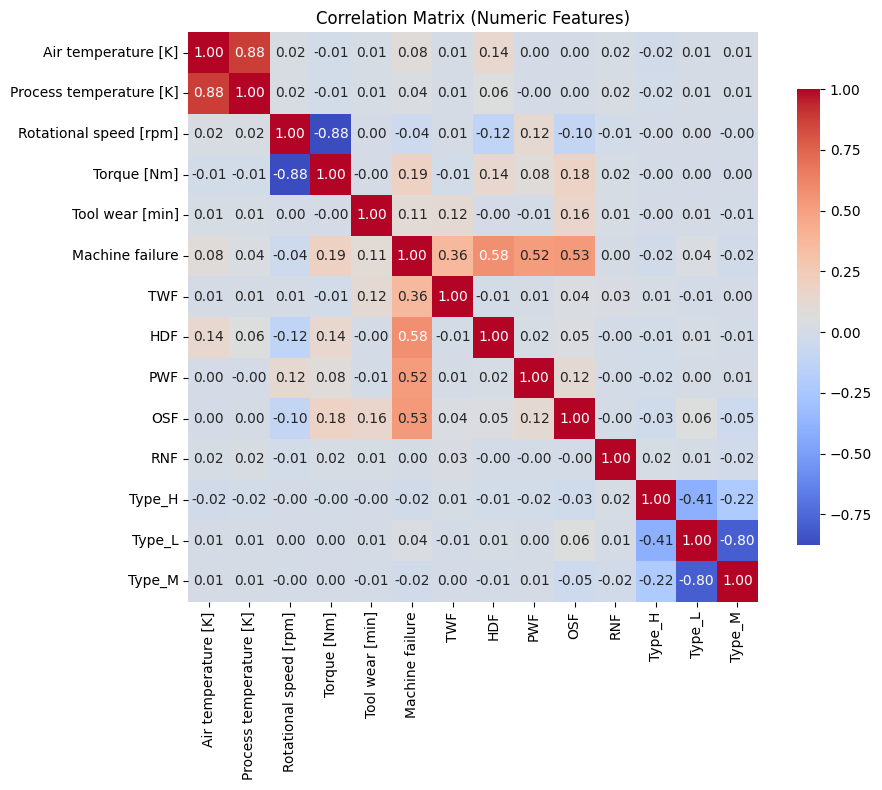

In [78]:
corr = mill_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()


## Correlation Matrix Interpretation – Predictive Maintenance Dataset

This correlation matrix provides a detailed view of linear relationships between features in a predictive maintenance dataset.  
Correlation values range from **-1.0** (perfect inverse relationship) to **1.0** (perfect direct relationship), while **0** indicates no linear correlation.

---

## 1. Strong Positive Correlations (Red)

Strong positive correlations indicate feature pairs that tend to increase together.

### Air Temperature & Process Temperature (**0.88**)
This is the strongest positive correlation among physical attributes.  
It suggests that as ambient air temperature increases, the internal process temperature of the machine follows closely—consistent with thermal transfer behavior in industrial systems.

### Machine Failure & Specific Failure Modes
The target variable **Machine failure** shows moderate to strong correlations with several specific failure types:

- **HDF (Heat Dissipation Failure): 0.58**
- **OSF (Overstrain Failure): 0.53**
- **PWF (Power Failure): 0.52**
- **TWF (Tool Wear Failure): 0.36**

Among these, **HDF exhibits the strongest association**, suggesting that heat dissipation issues are a dominant contributor to overall machine failure in this dataset.

> Note: Correlation reflects association, not causality. These values do not imply that a specific failure mode directly causes machine failure, only that they co-occur frequently.

---

## 2. Strong Negative Correlations (Blue)

Strong negative correlations indicate inverse relationships.

### Rotational Speed & Torque (**-0.88**)
This is a very strong inverse correlation, which aligns with fundamental physics:

\[
\text{Power} = \text{Torque} \times \omega
\]

At a given power level, higher rotational speed (RPM) implies lower torque (Nm), and vice versa.  
This relationship is expected and validates the physical consistency of the dataset.

---

## 3. Weak or Negligible Correlations (Grey)

Most other feature pairs exhibit correlations close to **0.00**, indicating weak or no linear relationships.

### UDI (Unique Device Identifier)
UDI shows near-zero correlation with most physical variables and failure indicators, as expected for an identifier.  
A small correlation with process temperature (**0.32**) is likely incidental and reflects data ordering rather than a meaningful relationship.

### RNF (Random Failures)
RNF shows almost **no correlation** with other features, confirming its intended definition:  
random failures that cannot be predicted from available sensor measurements.

### Tool Wear
Tool wear has weak correlations with temperature, speed, and torque, suggesting that wear progression occurs relatively independently of short-term operating conditions captured in this dataset.

---

## Key Takeaways for Modeling

### Redundancy & Multicollinearity
- **Air Temperature vs. Process Temperature**
- **Rotational Speed vs. Torque**

These highly correlated pairs may introduce multicollinearity in linear models (e.g., Logistic Regression).  
Consider removing one feature from each pair or applying regularization.

### Strong Predictors of Machine Failure
The most informative features for predicting **Machine failure** are:
- **HDF**
- **OSF**
- **PWF**

These features show the strongest associations with the target variable.

### Complementary Information
Features such as **Tool Wear** and **Rotational Speed** exhibit low correlation with temperature-related variables, indicating that they may contribute **independent signal** to machine learning models.

---

## Final Note
Correlation analysis is a useful exploratory tool, but it captures only **linear pairwise relationships**.  
For predictive modeling, feature importance, permutation importance, and time-aware validation should be used to confirm true predictive value.


In [53]:
# one-hot encode the 'Type' column
mill_df = pd.get_dummies(mill_df, columns=['Type'], prefix='Type')
mill_df.head()

,UDI,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,1,M14860,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,False,False,True
1,2,L47181,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,False,True,False
2,3,L47182,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,False,True,False
3,4,L47183,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,False,True,False
4,5,L47184,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,False,True,False


In [ ]:
mill_df.drop(columns=['UDI', 'Product ID'], axis=1, inplace=True)

KeyError: "['UDI', 'Product ID'] not found in axis"

## Modelling Prediction

In [66]:
def build_failure_pipeline(mill_df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    # Split features/target
    if "Machine failure" not in mill_df.columns:
        raise ValueError("Column 'Machine failure' not found in mill_df.")
    y = mill_df["Machine failure"]
    X = mill_df.drop(columns=["Machine failure"])

    # Auto-detect feature types
    numeric_features = X.select_dtypes(include=["number", "bool"]).columns.tolist()
    categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

    # Preprocessing
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    # Classifier (handles imbalance via class_weight)
    clf = LogisticRegression(
        max_iter=1000,
        solver="lbfgs",
        penalty="l2",
        class_weight="balanced"
    )

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", clf)
    ])

    # Train/test split
    stratify = y if len(np.unique(y)) > 1 else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify
    )

    # Simple hyperparameter search
    param_grid = {
        "clf__C": [0.1, 1.0, 10.0]
    }
    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model.named_steps["clf"], "predict_proba") else None

    metrics = {
        "best_params": grid.best_params_,
        "roc_auc": float(roc_auc_score(y_test, y_prob)) if y_prob is not None else None,
        "report": classification_report(y_test, y_pred, digits=4)
    }

    # Save model
    joblib.dump(best_model, "failure_pipeline.pkl")

    return best_model, metrics, X_test, y_test

In [69]:
best_model, metrics, X_test, y_test = build_failure_pipeline(mill_df)

model, metrics, X_test, y_test = build_failure_pipeline(mill_df)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Best params:", metrics["best_params"])
print("ROC AUC:", metrics["roc_auc"])
print(metrics["report"])

Best params: {'clf__C': 0.1}
ROC AUC: 0.972711910851297
              precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995      1932
           1     1.0000    0.9706    0.9851        68

    accuracy                         0.9990      2000
   macro avg     0.9995    0.9853    0.9923      2000
weighted avg     0.9990    0.9990    0.9990      2000



<Figure size 500x500 with 0 Axes>

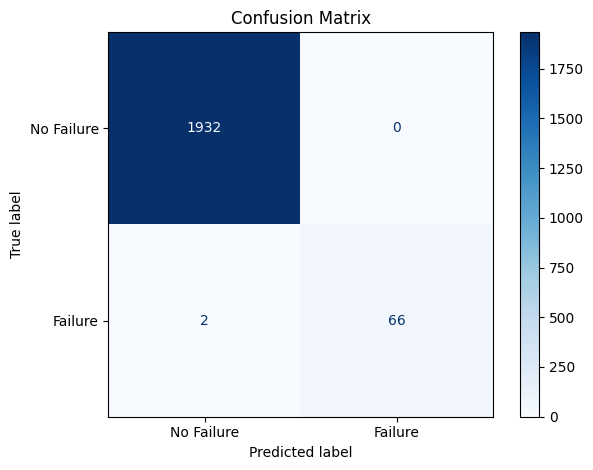

In [70]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Failure", "Failure"]
)

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


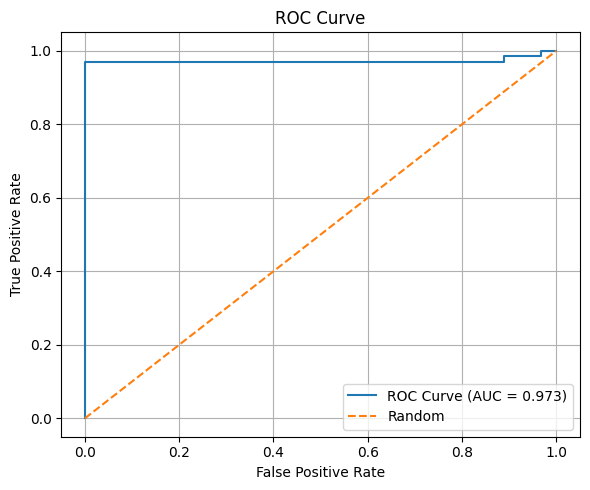

In [71]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [74]:
def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if transformer == "drop" or len(cols) == 0:
            continue

        if name == "num":
            feature_names.extend(cols)

        elif name == "cat":
            ohe = transformer.named_steps["onehot"]

            # 🔐 safe access
            ohe_features = ohe.get_feature_names_out(cols)
            feature_names.extend(ohe_features)

    return feature_names

In [76]:
feature_names = model.named_steps["preprocess"].get_feature_names_out()
coefficients = model.named_steps["clf"].coef_[0]

importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefficients,
        "abs_coefficient": np.abs(coefficients)
    })
    .sort_values("abs_coefficient", ascending=False)
)

importance_df.head(15)

,feature,coefficient,abs_coefficient
7,num__PWF,1.152915,1.152915
8,num__OSF,1.092111,1.092111
6,num__HDF,1.041704,1.041704
5,num__TWF,0.761105,0.761105
0,num__Air temperature [K],0.573570,0.573570
11,num__Type_L,-0.300159,0.300159
12,num__Type_M,0.255288,0.255288
3,num__Torque [Nm],0.237137,0.237137
1,num__Process temperature [K],-0.112562,0.112562
10,num__Type_H,0.100926,0.100926


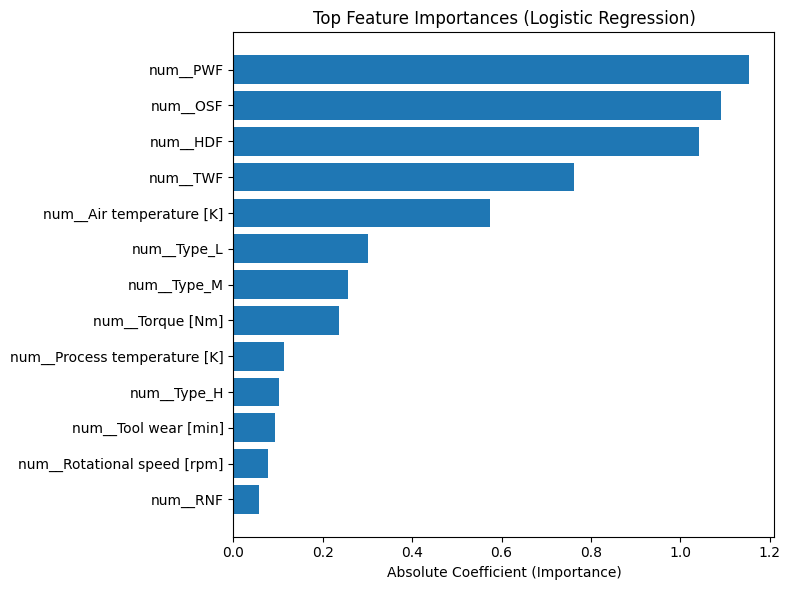

In [77]:
TOP_N = 20

top_features = importance_df.head(TOP_N)

plt.figure(figsize=(8, 6))
plt.barh(
    top_features["feature"],
    top_features["abs_coefficient"]
)
plt.gca().invert_yaxis()
plt.xlabel("Absolute Coefficient (Importance)")
plt.title("Top Feature Importances (Logistic Regression)")
plt.tight_layout()
plt.show()
